### Examples of how to use btk to asses detection algorithm performance 
This tutorial shows how to run btk on blended image with a user defined detection algorithm and get detection metrics. 

Detection metrics are computed for:
1. Finding local maxima (skimage.feature.peak_local_max)
2. SEP (Sextractor)
2. DM Stack (LSST Science Pipeline)

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import os
import sys
import numpy as np

#import scarlet.display to plot RGB images if scarelt is installed
if 'scarlet' in sys.modules:
    import scarlet.display

sys.path.insert(0,os.path.dirname(os.getcwd()))
import btk
from btk import config

In [76]:
# Functions helpful for plotting blend images
def get_rgb(image, min_val=None, max_val=None):
    """Basic function to normalize 3 band input image to rgb 0-255 image"""
    assert image.shape[0] == 3, "must be 3 channel in dimension 1"
    if min_val is None:
        min_val = image.min(axis=-1).min(axis=-1) 
    if max_val is None:
        max_val = image.max(axis=-1).max(axis=-1) 
    new_image = np.transpose(image, axes=(1,2,0))
    new_image = (new_image - min_val) / (max_val-min_val)*255
    new_image[new_image<0] = 0
    new_image[new_image>255] = 255
    return new_image.astype(np.uint8)

def get_rgb_image(image, normalize_with_image=None):
    """Returns RGB (0-255) image corresponding to the input 3 band image.
    If scarlet.display is imported then the normalization is performed by
    scarlet Asinh function. If not, a basic normalization is performed."""
    if 'scarlet.display' not in sys.modules:
        if normalize_with_image is None:
            min_val = None
            max_val = None
        else:
            min_val = np.min(normalize_with_image, axis=1).min(axis=-1)
            max_val = np.max(normalize_with_image, axis=1).max(axis=-1)
        img_rgb = get_rgb(image, min_val=min_val, max_val=max_val)
    else:
        norm = scarlet.display.Asinh(img=normalize_with_image, Q=20)
        img_rgb = scarlet.display.img_to_rgb(image, norm=norm)
    return img_rgb

def plot_blends( blend_images, blend_list, detected_centers=None, limits=None):
    """Plots blend images as RGB(g,r,i) image, sum in all bands, and RGB with centers of objects marked"""
    batch_size = len(blend_list)
    if detected_centers is None:
        detected_centers = [[]]*batch_size
    for i in range(batch_size):    
        num = len(blend_list[i])
        images = np.transpose(blend_images[i, :, :, 1:4], axes=(2,0,1))
        blend_img_rgb = get_rgb_image(images)
        fig, ax = plt.subplots(1, 3, figsize=(8, 3))
        ax[0].imshow(blend_img_rgb)
        if limits:
            ax[0].set_xlim(limits)
            ax[0].set_ylim(limits)
        ax[0].set_title("gri bands")
        ax[0].axis('off')

        ax[1].imshow(np.sum(blend_images[i, :, :, :], axis=2))
        ax[1].set_title("Sum")
        if limits:
            ax[1].set_xlim(limits)
            ax[1].set_ylim(limits)
        ax[1].axis('off')


        ax[2].imshow(blend_img_rgb)
        ax[2].set_title("%i objects with centers"%num)
        for entry in blend_list[i]:
            ax[2].plot(entry['dx'], entry['dy'],'rx')
        if limits:
            ax[2].set_xlim(limits)
            ax[2].set_ylim(limits)
        for cent in detected_centers[i]:
            ax[2].plot(cent[0], cent[1],'go', fillstyle='none', ms=10, mew=2)
        ax[2].axis('off')
    plt.show()

def plot_metrics_summary(summary, num, ax=None):
    if ax is None:
        _, ax = plt.subplots(1,1,figsize=(3, 3))
    results_table = np.zeros((num + 1, num + 1))
    for i in range(num + 1):
        q_true, = np.where(summary[:, 0] == i)
        for j in range(num):
            if len(q_true)>0:
                q_det, = np.where(summary[q_true, 1] == j) 
                results_table[j, i] = len(q_det)
    cmap = ax.imshow(results_table/ float(len(summary)) *100, origin='left')
    cbar = plt.colorbar(cmap, ax=ax)
    cbar.set_label('% of blends')
    ax.set_xlabel("# true objects")
    ax.set_ylabel("# detected objects")
    
def plot_cumulative(true_table, detected_table, column_name, axs, bins=40, color='red'):
    det_values, det_base = np.histogram(detected_table[column_name], bins=bins)
    det_cumulative = np.cumsum(det_values)
    true_values, true_base = np.histogram(true_table[column_name], bins=bins)
    true_cumulative = np.cumsum(true_values)
    axs[0].plot(det_base[:-1], det_cumulative, c=color)
    axs[0].plot(true_base[:-1], true_cumulative, c='blue')
    #axs[0].set_xlabel(column_name)
    axs[0].set_ylabel('cumulative counts')
    axs[1].plot(true_base[:-1], true_cumulative-det_cumulative, c=color , marker='o', linestyle='')
    axs[1].set_xlabel(column_name)
    axs[1].set_ylabel('difference in cumulative counts')
    
def plot_detection_cumulative(true_table):
    q_detected, = np.where(true_table['num_dectections'] ==1)
    _, axs = plt.subplots(2,3,figsize=(12,8))
    plt.subplots_adjust(wspace=0.5, hspace=0.)
    # Plot by magnitude
    mag_bins = np.linspace(18, 27, 40)
    plot_cumulative(true_table, true_table[q_detected], 'i_ab', [axs[0,0], axs[1,0]], mag_bins)
    # Plot by size
    size_bins = np.linspace(0, 20, 40)
    plot_cumulative(true_table, true_table[q_detected], 'size', [axs[0,1], axs[1,1]], size_bins)
    # Plot by min dist to neighbor
    dist_bins = np.linspace(0, 20, 40)
    plot_cumulative(true_table, true_table[q_detected], 'min_dist', [axs[0,2], axs[1,2]], dist_bins)
    plt.show()
    
def get_meas_generator(meas_params):
    """Returns generator that yields output of user defined algorithm specified in meas_param.
    
    Measurements are performed for default sampling function with maximum of 6 objects per blend.
    
    Returns:
        meas_generator: Generator that yeilds output of deblender and measurement algorithm..
    """
    # Load parameters
    #Input catalog name
    catalog_name = os.path.join(os.path.dirname(os.getcwd()), 'data', 'OneDegSq.fits')
    param = config.Simulation_params(catalog_name,batch_size=4, max_number=6 )
    np.random.seed(param.seed)

    #Load input catalog
    catalog = btk.get_input_catalog.load_catalog(param)

    #Generate catlogs of blended objects 
    blend_generator = btk.create_blend_generator.generate(param, catalog)

    #Generates observing conditions for the selected survey_name and all input bands
    observing_generator = btk.create_observing_generator.generate(param)

    np.random.seed(int(param.seed))
    #Generate images of blends in all the observing bands
    draw_blend_generator = btk.draw_blends.generate(param, blend_generator, observing_generator) 
    # get generator that yields measured values.
    meas_generator = btk.measure.generate(
            meas_params, draw_blend_generator, param)
    
    return meas_generator, param

## Finding local maxima with [scikit-image.peak_local_max](https://scikit-image.org/docs/dev/auto_examples/segmentation/plot_peak_local_max.html)

Note: This requires skimage to have been installed

In [3]:
meas_param = btk.utils.Basic_measure_params()
meas_generator, param = get_meas_generator(meas_param)
metric_param = btk.utils.Basic_metric_params(meas_generator=meas_generator, param=param)
results = btk.compute_metrics.run(metric_param, test_size=1)
true_p, detected_p, blend_list_p = results['detection']

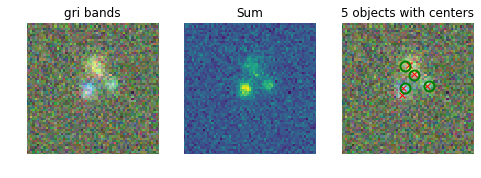

Out of 5 true objects 4 were detected,1 were undetected with 0 shredded
Out of 4 detections,4 were matched, 0 were spurious


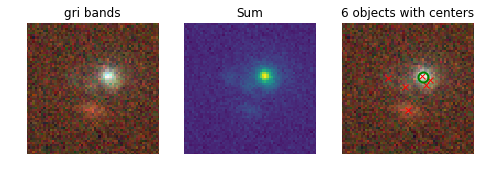

Out of 6 true objects 1 were detected,5 were undetected with 0 shredded
Out of 1 detections,1 were matched, 0 were spurious


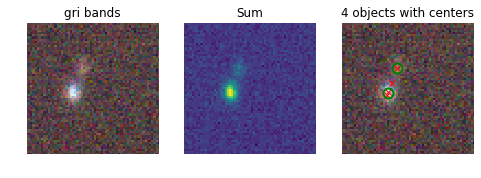

Out of 4 true objects 2 were detected,2 were undetected with 0 shredded
Out of 2 detections,2 were matched, 0 were spurious


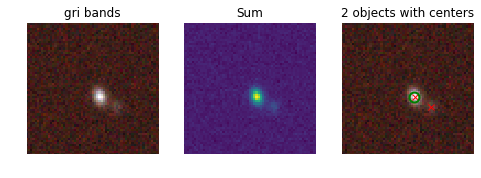

Out of 2 true objects 1 were detected,1 were undetected with 0 shredded
Out of 1 detections,1 were matched, 0 were spurious


In [4]:
meas_params = btk.utils.Basic_measure_params()
meas_generator, param = get_meas_generator(meas_param)
output, deb, _ = next(meas_generator)
blend_list = output['blend_list']
figs = []
count = 0
for i in range(len(blend_list)):
    blend_images = output['blend_images'][i:i+1]
    detected_centers = deb[i]['peaks']
    true_centers = np.stack([blend_list[i]['dx'], blend_list[i]['dy']]).T
    plot_blends(blend_images, blend_list[i: i+1], [detected_centers],limits=(30,90))
    num, det, undet, spur, shred = blend_list_p[i]
    print(f"Out of {num} true objects {det} were detected,"
          f"{undet} were undetected with {shred} shredded")
    blend_detected = detected_p[detected_p['blend_index']==i]
    print(f"Out of {len(blend_detected)} detections,"
          f"{len(blend_detected[blend_detected['match_id']!=-1])} were matched, {spur} were spurious")

## Detectection metrics

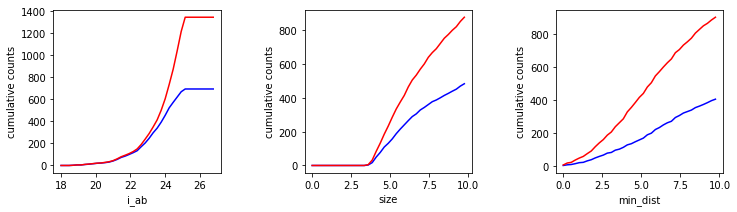

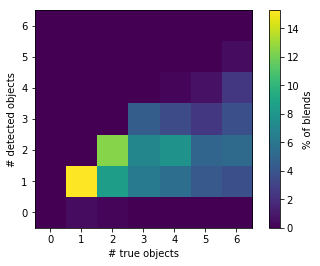

In [5]:
meas_param = btk.utils.Basic_measure_params()
meas_generator, param = get_meas_generator(meas_param)
metric_param = btk.utils.Basic_metric_params(meas_generator=meas_generator, param=param)
results = btk.compute_metrics.run(metric_param, test_size=100)

true_table, detected_table, detection_summary = results['detection']
plot_detection_cumulative(true_table)

det_summary = np.array(detection_summary)
num = np.max(det_summary)

plot_metrics_summary(det_summary, num)

## Detectection metrics for SEP

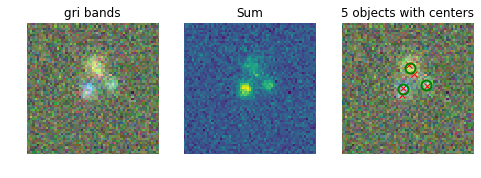

Out of 5 true objects 3 were detected,2 were undetected with 0 shredded
Out of 3 detections,3 were matched, 0 were spurious


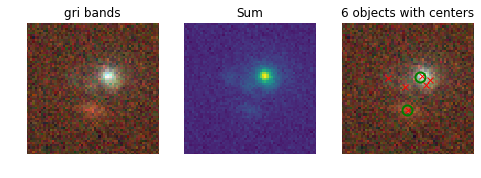

Out of 6 true objects 2 were detected,4 were undetected with 0 shredded
Out of 2 detections,2 were matched, 0 were spurious


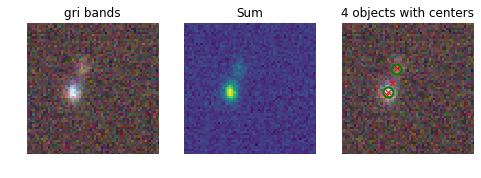

Out of 4 true objects 2 were detected,2 were undetected with 0 shredded
Out of 2 detections,2 were matched, 0 were spurious


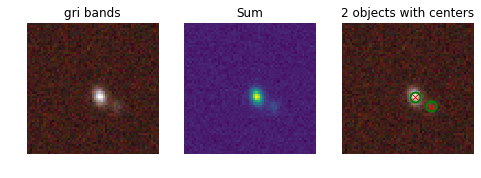

Out of 2 true objects 2 were detected,0 were undetected with 0 shredded
Out of 2 detections,2 were matched, 0 were spurious


In [6]:
meas_param = btk.utils.SEP_params()
meas_generator, param = get_meas_generator(meas_param)
metric_param = btk.utils.Basic_metric_params(meas_generator=meas_generator, param=param)
results = btk.compute_metrics.run(metric_param, test_size=1)
true_p, detected_p, blend_list_p = results['detection']

meas_param = btk.utils.SEP_params()
meas_generator, param = get_meas_generator(meas_param)
output, deb, _ = next(meas_generator)
blend_list = output['blend_list']
figs = []
count = 0
for i in range(len(blend_list)):
    blend_images = output['blend_images'][i:i+1]
    detected_centers = deb[i]['peaks']
    true_centers = np.stack([blend_list[i]['dx'], blend_list[i]['dy']]).T
    plot_blends(blend_images, blend_list[i: i+1], [detected_centers],limits=(30,90))
    num, det, undet, spur, shred = blend_list_p[i]
    print(f"Out of {num} true objects {det} were detected,"
          f"{undet} were undetected with {shred} shredded")
    blend_detected = detected_p[detected_p['blend_index']==i]
    print(f"Out of {len(blend_detected)} detections,"
          f"{len(blend_detected[blend_detected['match_id']!=-1])} were matched, {spur} were spurious")

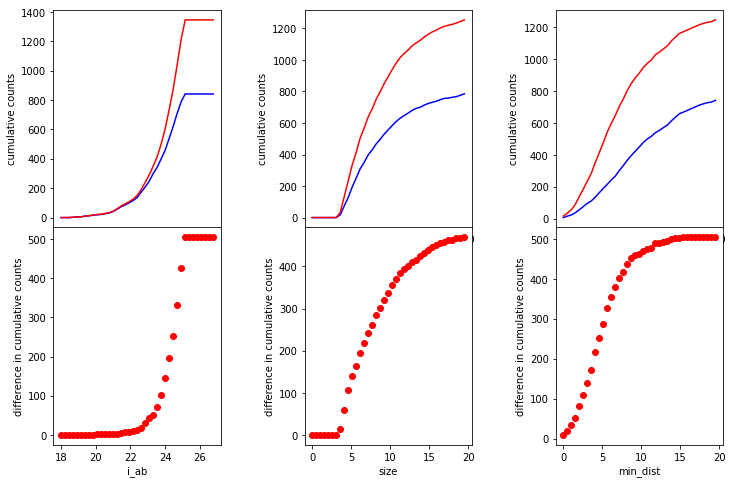

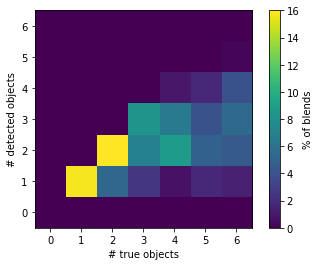

In [40]:
meas_param = btk.utils.SEP_params()
meas_generator, param = get_meas_generator(meas_param)
metric_param = btk.utils.Basic_metric_params(meas_generator=meas_generator, param=param)
results = btk.compute_metrics.run(metric_param, test_size=100)

true_table, detected_table, detection_summary = results['detection']
plot_detection_cumulative(true_table)

det_summary = np.array(detection_summary)
num = np.max(det_summary)
plot_metrics_summary(det_summary, num)

In [ ]:
# Compare differetnt detection algorithms

In [ ]:
meas_params = [btk.utils.SEP_params(), btk.utils.Basic_measure_params()]
algorithms = ['sep', 'find_peak']
colors = ['red', 'green']
results ={}
for i, meas_param in enumerate(meas_params):
    meas_generator, param = get_meas_generator(meas_param)
    metric_param = btk.utils.Basic_metric_params(meas_generator=meas_generator, param=param)
    results[algorithms[i]] = btk.compute_metrics.run(metric_param, test_size=10)

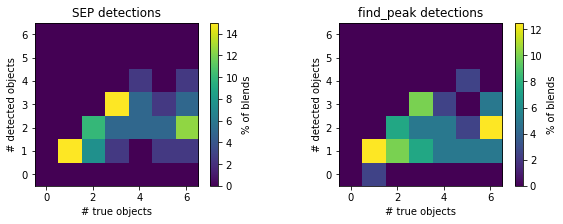

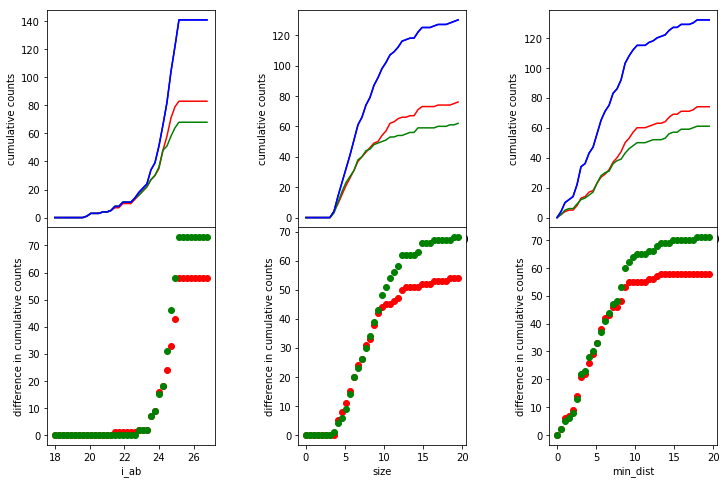

In [77]:
num = np.max([np.array(results[a]['detection'][2]).max() for a in algorithms])

_, ax = plt.subplots(1,2,figsize=(10,3))
plt.subplots_adjust(hspace=0.5)
det_summary_sep = np.array(results['sep']['detection'][2])
plot_metrics_summary(det_summary_sep, num, ax=ax[0])
ax[0].set_title('SEP detections')
det_summary_peak = np.array(results['find_peak']['detection'][2])
plot_metrics_summary(det_summary_peak, num, ax=ax[1])
ax[1].set_title('find_peak detections')
plt.show()

_, axs = plt.subplots(2,3,figsize=(12,8))
plt.subplots_adjust(wspace=0.5, hspace=0.)
mag_bins = np.linspace(18, 27, 40)
size_bins = np.linspace(0, 20, 40)
dist_bins = np.linspace(0, 20, 40)
for i, algorithm in enumerate(algorithms):
    true_table = results[algorithm]['detection'][0]
    q_detected, = np.where(true_table['num_dectections'] ==1)
    # Plot by magnitude    
    plot_cumulative(true_table, true_table[q_detected], 'i_ab', [axs[0,0], axs[1,0]], mag_bins, color=colors[i])
    # Plot by size
    plot_cumulative(true_table, true_table[q_detected], 'size', [axs[0,1], axs[1,1]], size_bins, color=colors[i])
    # Plot by min dist to neighbor 
    plot_cumulative(true_table, true_table[q_detected], 'min_dist', [axs[0,2], axs[1,2]], dist_bins, color=colors[i])
plt.show()